# How Convolutional Neural Networks (CNNs) Work — Detailed, Step-by-Step Notebook
- You will learn: convolution math, stride, padding, filters, multi-channel convolution, pooling, activations, flattening and fully connected layer.

## 1) Image & tensor basics
A grayscale image is a 2D tensor (height × width). A color image (RGB) is a 3D tensor (height × width × channels). Machine learning libraries usually represent batches as 4D tensors: (batch, height, width, channels) or (batch, channels, height, width).

We'll start with tiny example arrays so every calculation fits on-screen.


In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
# small grayscale image (5x5)
img = np.array([
    [1, 2, 3, 0, 1],
    [4, 5, 6, 1, 2],
    [7, 8, 9, 0, 3],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0]
], dtype=float)
print("Grayscale image (5x5):\n", img)

Grayscale image (5x5):
 [[1. 2. 3. 0. 1.]
 [4. 5. 6. 1. 2.]
 [7. 8. 9. 0. 3.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]


## 2) Convolution operation — manual math
Convolution uses a kernel (filter) that multiplies element-wise with a patch of the image and sums the results (dot product). For a 3×3 kernel sliding over a 5×5 image (no padding, stride=1), you'll get a (5-3+1)=3 sized output in each spatial dimension (3×3 output).


In [3]:
# 3x3 filter (edge detection-like)
kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=float)

In [4]:
print("Kernel:\n", kernel)

Kernel:
 [[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


In [5]:
# Manual convolution at the top-left position (i=0,j=0)
patch = img[0:3, 0:3]
print("\nPatch at position (0,0):\n", patch)


Patch at position (0,0):
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


In [6]:
dot = (patch * kernel).sum()
print("\nElement-wise product:\n", patch * kernel)
print("\nDot product (sum):", dot)


Element-wise product:
 [[-1. -2. -3.]
 [-4. 40. -6.]
 [-7. -8. -9.]]

Dot product (sum): 0.0


In [7]:
# Compute full 'valid' convolution (no padding, stride=1) manually
H, W = img.shape
F, _ = kernel.shape
out_h = H - F + 1
out_w = W - F + 1
output = np.zeros((out_h, out_w))
for i in range(out_h):
    for j in range(out_w):
        patch = img[i:i+F, j:j+F]
        output[i,j] = (patch * kernel).sum()
print("\nFull valid convolution output:\n", output)


Full valid convolution output:
 [[  0.  20. -16.]
 [ 30.  49. -24.]
 [-18. -11.  -6.]]


## 3) Output size formula (padding & stride)
For input width/height `W`, filter size `F`, padding `P`, stride `S` the output size `O` is:

```
O = floor((W - F + 2P) / S) + 1
```

Let's show this with examples and verify numerically.


In [8]:
def conv_output_size(W, F, P, S):
    return (W - F + 2*P) // S + 1

examples = [
    (5, 3, 0, 1), # valid, stride 1
    (5, 3, 1, 1), # same-ish padding, stride 1
    (5, 3, 0, 2), # stride 2
    (6, 3, 1, 2)  # even case
]

for W,F,P,S in examples:
    print(f"W={W}, F={F}, P={P}, S={S} -> O = {conv_output_size(W,F,P,S)}")

W=5, F=3, P=0, S=1 -> O = 3
W=5, F=3, P=1, S=1 -> O = 5
W=5, F=3, P=0, S=2 -> O = 2
W=6, F=3, P=1, S=2 -> O = 3


## 4) Multiple filters & multi-channel convolution
For RGB images (H×W×3) a convolutional filter has the same depth as the input channels (e.g., 3). For each filter you do a per-channel convolution and **sum** them, then add a bias. If you have K filters you get K feature maps (output depth K).

Mathematically, for filter k with weights w_k (shape F×F×C) and bias b_k:

```
feature_map_k[i,j] = sum_{c=1..C} sum_{u=1..F} sum_{v=1..F} w_k[u,v,c] * input[i+u-1, j+v-1, c] + b_k
```

Let's compute a small 3-channel example by hand.


In [10]:
# Small 3-channel 'image'  (4x4 spatial, 3 channels) to keep math tiny
img3 = np.zeros((4,4,3), dtype=float)

In [11]:
# create a simple pattern across channels
for c in range(3):
    img3[:,:,c] = np.array([
        [1+c, 2+c, 3+c, 0],
        [4+c, 5+c, 6+c, 1],
        [7+c, 8+c, 9+c, 0],
        [1+c, 1+c, 1+c, 1]
    ])

In [12]:
print("Sample 4x4x3 image shape:", img3.shape)

Sample 4x4x3 image shape: (4, 4, 3)


In [13]:
# Create 2 filters (F=3) each with depth 3
np.random.seed(0)
filters = np.random.randn(2, 3, 3, 3) * 0.2  # shape (K, F, F, C)
biases = np.array([0.1, -0.05])

In [14]:
print("\nFilter 0 (3x3x3) slice for channel 0:\n", filters[0,:,:,0])
print("\nBiases:", biases)


Filter 0 (3x3x3) slice for channel 0:
 [[0.353 0.448 0.19 ]
 [0.082 0.152 0.067]
 [0.063 0.131 0.454]]

Biases: [ 0.1  -0.05]


In [15]:
# Compute 'valid' convolution for both filters (K=2)
H,W,C = img3.shape
F = 3
out_h = H - F + 1
out_w = W - F + 1
feature_maps = np.zeros((2, out_h, out_w))
for k in range(2):
    for i in range(out_h):
        for j in range(out_w):
            total = 0.0
            for c in range(C):
                patch = img3[i:i+F, j:j+F, c]
                total += (patch * filters[k,:,:,c]).sum()
            total += biases[k]
            feature_maps[k,i,j] = total

In [16]:
print("\nFeature maps shape (K, out_h, out_w):", feature_maps.shape)
print("\nFeature map 0:\n", feature_maps[0])
print("\nFeature map 1:\n", feature_maps[1])


Feature maps shape (K, out_h, out_w): (2, 2, 2)

Feature map 0:
 [[ 5.562  3.558]
 [13.968 12.401]]

Feature map 1:
 [[-11.18   -7.248]
 [ -4.608  -1.216]]


## 5) Stride & Padding visual examples
Let's show how different padding (P) and stride (S) values change the convolution outputs for the small grayscale image. We'll implement a helper that applies padding then computes the convolution with stride.


In [17]:
def apply_conv(input_img, kernel, pad=0, stride=1):
    # pad
    if pad > 0:
        input_p = np.pad(input_img, ((pad,pad),(pad,pad)), mode='constant', constant_values=0)
    else:
        input_p = input_img.copy()
    H, W = input_p.shape
    F = kernel.shape[0]
    out_h = (H - F) // stride + 1
    out_w = (W - F) // stride + 1
    out = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            i0 = i * stride
            j0 = j * stride
            patch = input_p[i0:i0+F, j0:j0+F]
            out[i,j] = (patch * kernel).sum()
    return input_p, out

In [18]:
cases = [
    dict(pad=0, stride=1),
    dict(pad=1, stride=1),  # 'same' style
    dict(pad=0, stride=2)
]

In [19]:
for case in cases:
    ip, op = apply_conv(img, kernel, pad=case['pad'], stride=case['stride'])
    print(f"pad={case['pad']}, stride={case['stride']} -> padded shape: {ip.shape}, output shape: {op.shape}\n{op}\n")

pad=0, stride=1 -> padded shape: (5, 5), output shape: (3, 3)
[[  0.  20. -16.]
 [ 30.  49. -24.]
 [-18. -11.  -6.]]

pad=1, stride=1 -> padded shape: (7, 7), output shape: (5, 5)
[[ -3.  -3.  10. -13.   5.]
 [  9.   0.  20. -16.  11.]
 [ 37.  30.  49. -24.  19.]
 [ -8. -18. -11.  -6.   4.]
 [ -2.  -3.  -3.  -3.  -2.]]

pad=0, stride=2 -> padded shape: (5, 5), output shape: (2, 2)
[[  0. -16.]
 [-18.  -6.]]



## 6) Pooling (Max & Average)
Pooling reduces spatial size. For a pooling window `F` and stride `S`:

- **Max pooling** picks the maximum value in each window.
- **Average pooling** computes the mean in each window.

Let's compute pooling by hand (2×2 window, stride=2) on a small feature map.


In [20]:
fm = np.array([
    [1, 3, 2, 4],
    [5, 6, 1, 0],
    [2, 1, 2, 3],
    [0, 1, 4, 2]
], dtype=float)

In [21]:
print("Feature map (4x4):\n", fm)

Feature map (4x4):
 [[1. 3. 2. 4.]
 [5. 6. 1. 0.]
 [2. 1. 2. 3.]
 [0. 1. 4. 2.]]


In [22]:
def pool2d(x, size=2, stride=2, mode='max'):
    out_h = (x.shape[0] - size) // stride + 1
    out_w = (x.shape[1] - size) // stride + 1
    out = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            patch = x[i*stride:i*stride+size, j*stride:j*stride+size]
            out[i,j] = patch.max() if mode=='max' else patch.mean()
    return out

In [23]:
print("\nMax pooling (2x2, stride=2):\n", pool2d(fm, size=2, stride=2, mode='max'))
print("\nAverage pooling (2x2, stride=2):\n", pool2d(fm, size=2, stride=2, mode='avg'))


Max pooling (2x2, stride=2):
 [[6. 4.]
 [2. 4.]]

Average pooling (2x2, stride=2):
 [[3.75 1.75]
 [1.   2.75]]


## 7) Activation functions — math & plots
Common activations:
- ReLU(x) = max(0, x)
- Sigmoid(x) = 1 / (1 + exp(-x))
- Tanh(x) = (exp(x)-exp(-x)) / (exp(x)+exp(-x))

ReLU is common in CNNs because it avoids vanishing gradients for positive inputs and is cheap to compute.


In [24]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-5,5,200)
relu = np.maximum(0,x)
sig = 1/(1+np.exp(-x))
tanh = np.tanh(x)

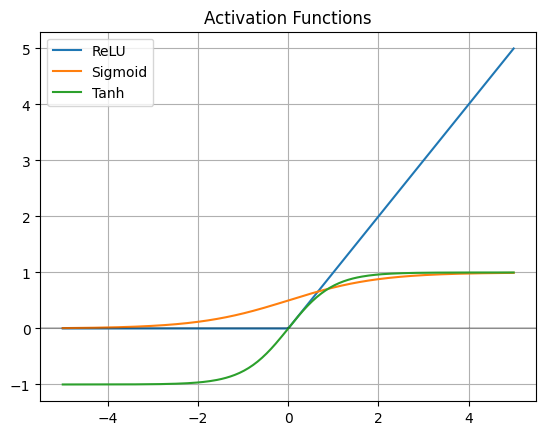

In [25]:
plt.plot(x, relu, label='ReLU')
plt.plot(x, sig, label='Sigmoid')
plt.plot(x, tanh, label='Tanh')
plt.axhline(0, color='k', linewidth=0.3)
plt.legend(); plt.grid(True); plt.title('Activation Functions'); plt.show()

## 8) Flatten → Fully Connected → Softmax
After several conv/pool layers we flatten the feature maps into a vector and apply a fully connected layer:

```
z = W x + b
```

For multi-class classification we apply **softmax**:

```
softmax(z)_i = exp(z_i) / sum_j exp(z_j)
```

Let's show a tiny numeric example: flatten a 2×2×2 tensor → FC(3 units) → softmax.


In [26]:
# tiny feature maps (2x2 with 2 channels)
fmaps = np.array([
    [[1., 2.],
     [3., 4.]],

    [[0., 1.],
     [1., 0.]]
])  # shape (2, 2, 2)? We'll shape to (H,W,C)

In [27]:
fm = np.stack([fmaps[0], fmaps[1]], axis=-1)
print("Feature maps (2x2x2):\n", fm)

Feature maps (2x2x2):
 [[[1. 0.]
  [2. 1.]]

 [[3. 1.]
  [4. 0.]]]


In [28]:
vec = fm.reshape(-1)  # flatten
print("\nFlattened vector:", vec)


Flattened vector: [1. 0. 2. 1. 3. 1. 4. 0.]


In [32]:
# small FC layer: 3 units
W = np.random.randn(3, vec.size)*0.1 # shape (3, vec.size)
b = np.random.randn(3)*0.01

In [33]:
z = W.dot(vec) + b
print("\nPre-activation (z):", z)


Pre-activation (z): [0.566 0.978 0.296]


In [34]:
def softmax(z):
    e = np.exp(z - np.max(z))
    return e / e.sum()

In [35]:
probs = softmax(z)
print("\nSoftmax probabilities:", probs)


Softmax probabilities: [0.305 0.461 0.233]


## 9) End-to-end small numeric CNN (forward pass)
We'll run a tiny forward pass: input (6×6 grayscale) → Conv(3x3, stride=1, pad=0) with 1 filter → ReLU → MaxPool(2x2) → Flatten → FC(2 classes) → Softmax.
This will show every shape and small numeric outputs.


In [36]:
# small 6x6 input
X = np.array([
 [1,2,3,0,1,2],
 [4,5,6,1,2,1],
 [7,8,9,0,3,1],
 [1,1,1,1,1,1],
 [0,0,0,2,2,2],
 [1,2,1,0,1,0]
], dtype=float)

In [37]:
print("Input X shape:", X.shape)

Input X shape: (6, 6)


In [38]:
# conv filter 3x3
K = np.array([
 [1,0,-1],
 [1,0,-1],
 [1,0,-1]
], dtype=float)  # simple vertical edge detector

In [39]:
# conv
def conv2d_single_filter(X, K, pad=0, stride=1):
    if pad>0:
        Xp = np.pad(X, ((pad,pad),(pad,pad)), 'constant')
    else:
        Xp = X.copy()
    H,W = Xp.shape
    F = K.shape[0]
    out_h = (H - F)//stride + 1
    out_w = (W - F)//stride + 1
    out = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            out[i,j] = (Xp[i*stride:i*stride+F, j*stride:j*stride+F] * K).sum()
    return out

In [40]:
conv_out = conv2d_single_filter(X, K, pad=0, stride=1)
print("\nConv output:\n", conv_out)


Conv output:
 [[-6. 14. 12. -3.]
 [-4. 12. 10. -1.]
 [-2.  6.  4. -1.]
 [ 0.  0. -2.  0.]]


In [41]:
# ReLU
relu_out = np.maximum(0, conv_out)
print("\nAfter ReLU:\n", relu_out)


After ReLU:
 [[ 0. 14. 12.  0.]
 [ 0. 12. 10.  0.]
 [ 0.  6.  4.  0.]
 [ 0.  0.  0.  0.]]


In [42]:
# MaxPool 2x2 stride 2
def pool2d_local(x, size=2, stride=2, mode='max'):
    out_h = (x.shape[0] - size) // stride + 1
    out_w = (x.shape[1] - size) // stride + 1
    out = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            patch = x[i*stride:i*stride+size, j*stride:j*stride+size]
            out[i,j] = patch.max() if mode=='max' else patch.mean()
    return out

In [43]:
pool_out = pool2d_local(relu_out, size=2, stride=2, mode='max')
print("\nAfter MaxPool:\n", pool_out)


After MaxPool:
 [[14. 12.]
 [ 6.  4.]]


In [44]:
# Flatten
vec = pool_out.reshape(-1)
print("\nFlattened vector:", vec)


Flattened vector: [14. 12.  6.  4.]


In [45]:
# FC -> 2 classes
W_fc = np.random.randn(2, vec.size)*0.1
b_fc = np.random.randn(2)*0.01
z = W_fc.dot(vec) + b_fc
probs = softmax(z)
print("\nOutput probs (2 classes):", probs)


Output probs (2 classes): [0.991 0.009]
